In [1]:
import numpy as np
from lanczos import *
from timeIntegration import *
from plotting import *
from utils import *
from IPython.display import display, HTML

# Project 2
The main goal of this project is to explore different ways of computing low rank approximations of matrices. 

## Exercise 1)
Here we compare Lanczos bidiagonalization with and without reorthogonalization with the rank $k$ best approximation of a random invertible matrix A. The rank $k$ approximation from the Lanczos bidiagonalization, $P_k B_k Q_k^T$, are denoted $W$, with the subscript $\perp$ if reorthogonalization is used. $X$ is the rank k best approximation: $X = \sum_{i=1}^k \sigma_i \vec u_i \vec v_i^T$.


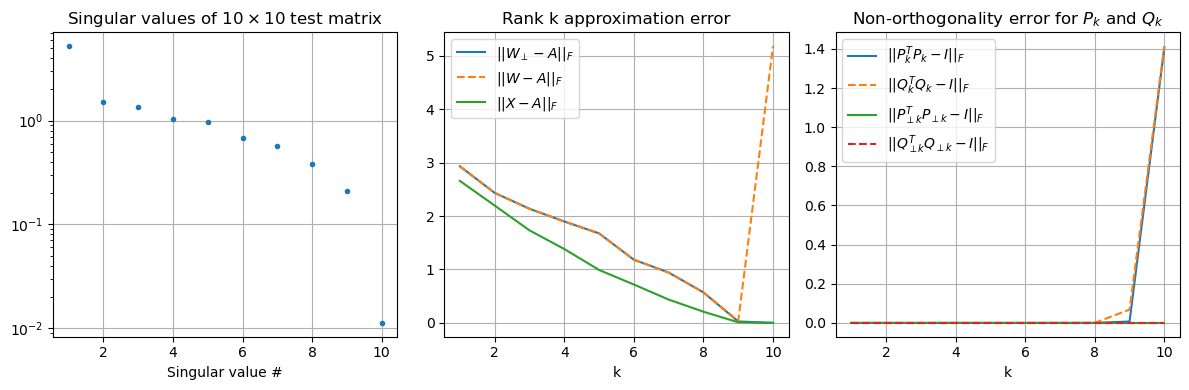

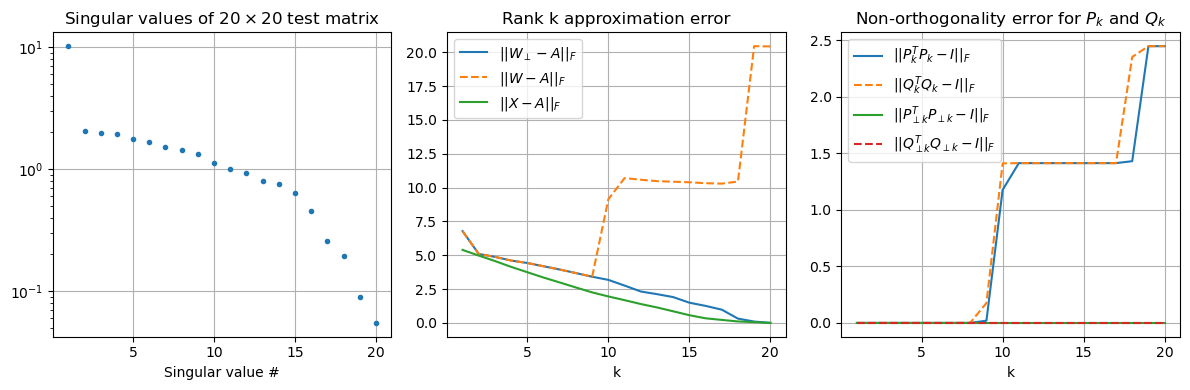

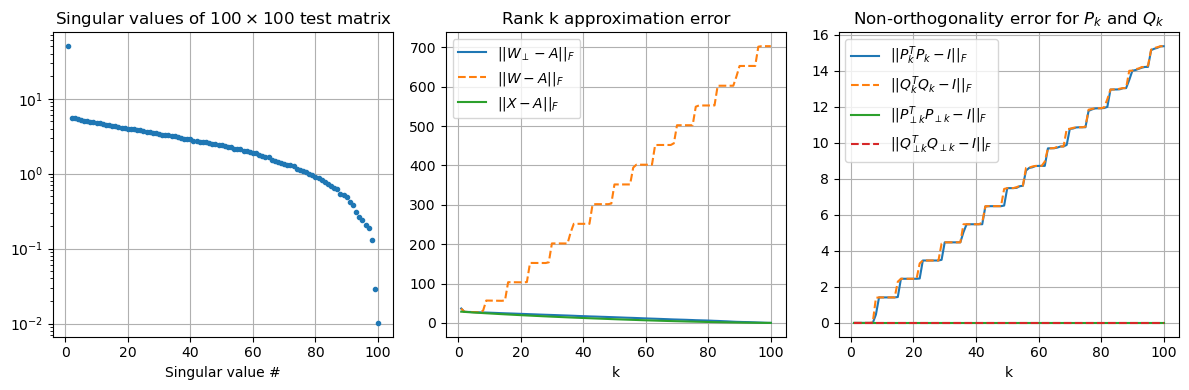

In [2]:
CompareRankkApproximation(ns=[10, 20, 100], res=4)

Here we observe that the best approximation is indeed best, and that the Lanczos approximation with reorthogonalization is close. We also observe that when $k = n$, the rank $k$ approximation of the random $n \times n$-matrix has zero error as expected. The Lanczos approximation without reorthogonalization is indistinguishable from the approximation with reorthogonalization for low $k$'s but the error quickly increases with increasing $k$, as does the non-orthogonality error of the matrices $P_k$ and $Q_k$. This shows that the reorthogonalization process is crucial for accuracy of the Lanczos approximation.

## Side quest 1) Efficient computation of the Cayley map
Here we explore a few different approaches to compute the Cayley map 
\begin{equation*}
    cay(B) = \left( I - \frac{1}{2}B \right)^{-1} \left(I + \frac{1}{2}B \right)
\end{equation*}

The first approach is to do the computation directly, i.e. computing the inverse of $ \left( I - \frac{1}{2}B \right)$ and then multiplying by $\left(I + \frac{1}{2}B \right)$

In the second approach we exploit how we are going to use the cayley map in this project; on a matrix on the form $B=CD^T, C = [F_U, -U], D=[U, F_U]$. Then the Cayley map can be computed as
\begin{equation*}
    cay(B) =  I + C \left(I-\frac{1}{2}D^TC\right)^{-1}D^T
\end{equation*}

This will be our second method. 

For the third and last approach we use QR factorization to compute the Cayley map as 
\begin{align*}
    cay(B) &= I + [U, U^T]G[U, U^T]^T
\end{align*}

Where $G$ is a matrix constructed using the QR factorization of $D$.


Here we run the three different algorithms for matrices $U, F_U \in \mathbb R^{3k\times k}$

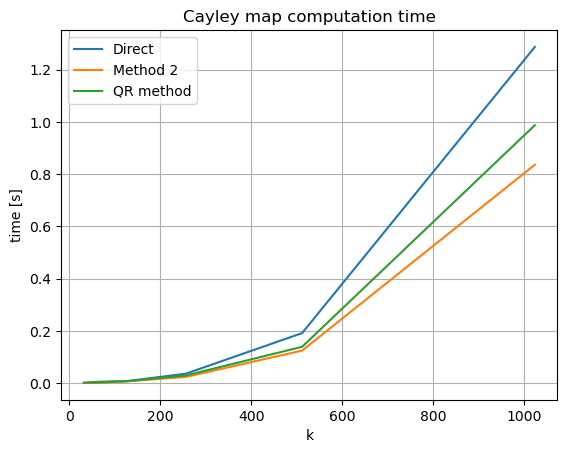

In [3]:
ks = [2**n for n in range(5, 10 + 1)]
dirtime, C1time, CQRtime = runCay(ks)
plotCayComp(dirtime, C1time, CQRtime, ks)


We see that both of the non-direct methods are faster than the direct method, and that the second method is fastest for large matrices. In this project the matrices are not that big, so we examine further what happens for small matrices. The computation time for small matrices varies greatly, so for each matrix size we average the run time over 200 runs.

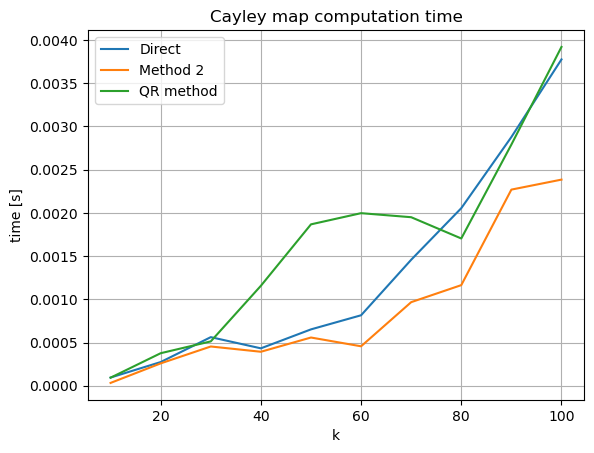

In [4]:
ks = list(range(10, 110, 10))
dirtime, C1time, CQRtime = runCay(ks, average=True)
plotCayComp(dirtime, C1time, CQRtime, ks)

Again we see that the second method is generally fastest, so that is the method we will use throughout this project. In the code this function is called *cay1*

## Exercise 3)
Here we compute a low rank approximation of a solution to the heat equation

\begin{aligned}
u_t & =u_{x x}+u_{y y} & & {[x, y]^T \in \Omega, t \in(0, T] } \\
u(x, y, 0) & =g(x, y) & & {[x, y]^T \in \Omega } \\
u(x, y, t) & =0 & & {[x, y]^T \in \partial \Omega, t \in(0, T] }
\end{aligned}

with exact know solution 
$u(x, y, t)=e^{-5 \pi^2 t} \sin (\pi x) \sin (2 \pi y)$ 

and

$g(x, y)=\sin (\pi x) \sin (2 \pi y)$. 

In our case $\Omega = [0, 1]\times [0,1]$ and $T=0.2$.


When evaluating $u$ on a grid, the resulting matrix is of rank 1, and therefore it is reasonable for the low-rank approximation to also be of rank 1, since it can't be any lower and it won't help being any higher.

We initiate the problem and plot the initial solution. 

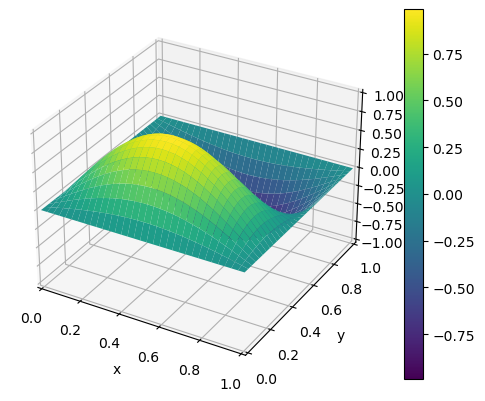

In [5]:
N = 32
k = 1

t0 = 0 #start time
tf = 0.2 #end time
h0 = 0.0005 #initial step size
A0 = initval(g, N) #Initial value
U0, S0, V0 = getU0S0V0(A0, k) #Initial U, S and V matrices, computed from the best approximation approach at t=0
TOL = 1e-5 #TOlerance for step size control
maxcuts = 3 #maximum number of time step cuts
# m = n = N+1
plotGrid3D(A0) # plot surface plot of initial solution

Now we do the approximation:

Starting integrating at t:0, with step size 0.0005
Finished integrating in 4401 steps, 1.6692478656768799s


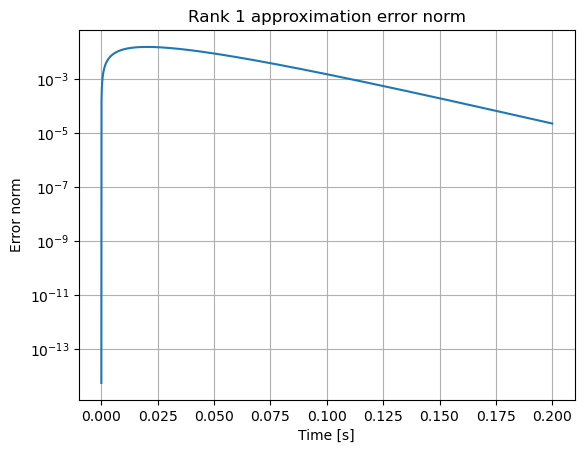

In [6]:
Ulist, Slist, Vlist, timesteps, dUlist, dSlist, dVlist, tRUn= TimeIntegration(t0, tf, h0, U0, S0, V0, 
                diff, linMatODEStep, 
                cay=cay1, verbose = 1,
                TOL= TOL, maxTimeCuts=maxcuts)
Ylist = makeY(Ulist, Slist, Vlist)
plotRankApproxError(Ylist, u, timesteps, k)

We see that the error is reasonable. At the beginning it is zero, then increases a bit as the true solution evolves, and then the error decreases as the solution approaches zero. Now we plot the columns of U and V at some arbitrarily chosen step:

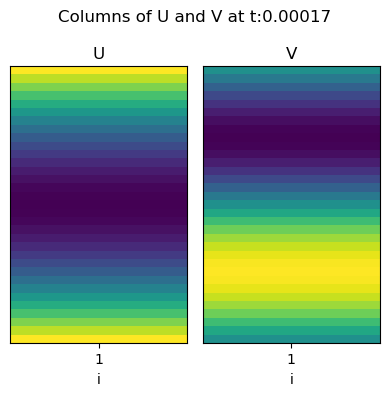

In [7]:
index = 10
plotCols(Ulist[index], Vlist[index], timesteps[index], res=2)

Here we clearly see that the single column of $U$ resembles a slice of the solution parallell to the x-axis and similiar for V and the y-axis. We know that in the SVD decomposition $A = USV^T$, the column space of $U$ equals the columns space of $A$ and the row space of $V$ equals the row space of $A$. From the plot of the solution we would expect that the U column has two peaks and the V column has one peak, but this is because the matrices are rotated $90$ degress in the code.

## Exercise 4)
Here we compute a low rank approximation of 

\begin{equation*}
    A(t)=Q_1(t)\left(A_1+e^t A_2\right) Q_2(t)^T, \quad t \in[0,1]
\end{equation*}

Which is computed as explained in the project description and in the article by Kock and Lubich. 

When contructing this function with $\epsilon > 0$, the matrix will be of full rank at all times. For $\epsilon = 0$ the matrix (of size $n^2 \times n^2$) will be of rank $n$, and the singular values $\sigma_m$ for $m>n$ will be zero. For nonzero $\epsilon$, the singular values $\sigma_m$ for $m>n$ will depend on the parameter $\epsilon$. 

This means that as $\epsilon$ decreases, so does the "effective" rank of $A(t)$ and it should be easier to compute a low-rank-approximation, and we expect the error to decrease. 


Below is an animation of this matrix with parameter $\epsilon=1e-3$

In [8]:
A, dA = makeAfuncs(eps=1e-3)
%matplotlib inline
name1 = animateMatrix(A)
HTML(f'<img src={name1} />')

MovieWriter Pillow unavailable; using Pillow instead.


Now we do the low rank time integration with different $\epsilon$'s used for constructing $A$.

In [9]:
# epss = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
epss = [1e-1, 1e-3, 1e-4, 1e-5]
ks = [10, 12, 20]
TOL = 1e-2
resultsByKByEps = {}
for k in ks:
    resultsByKByEps[k] = GetResults(epss=epss, k=k, verbose=0,
                            TOL=TOL)


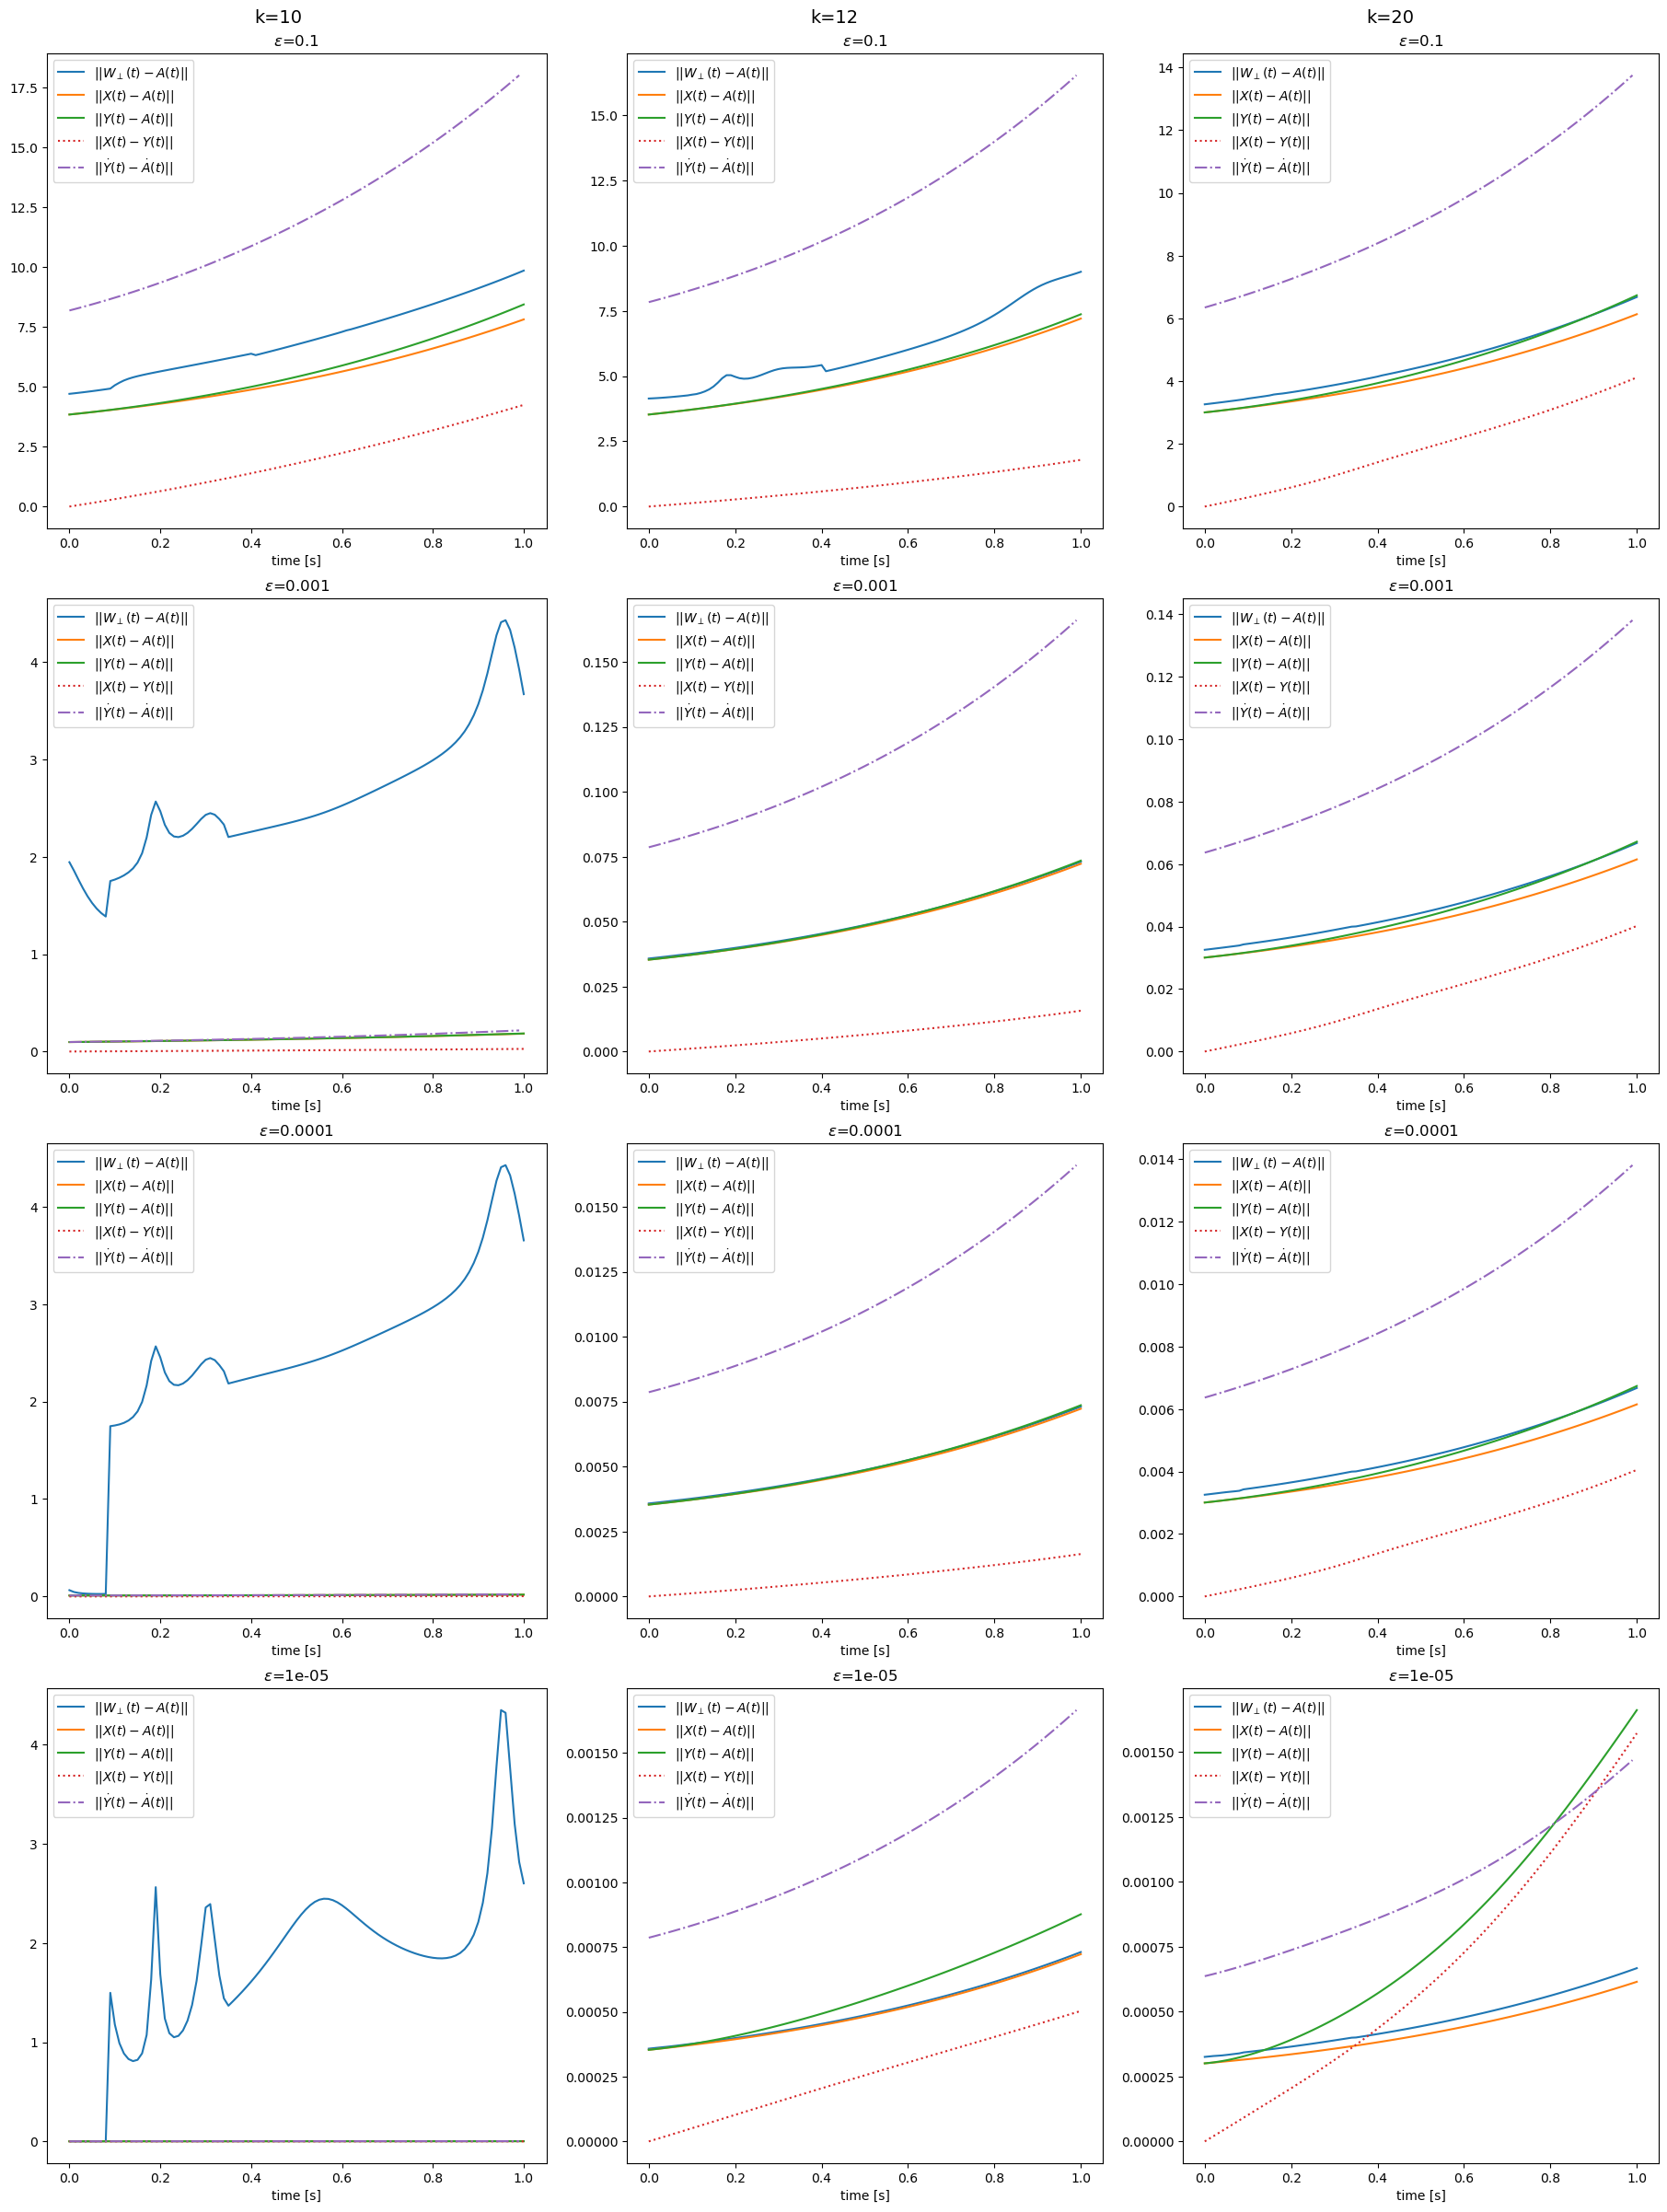

In [10]:
ksToPlot = len(ks)
epssToPlot = len(epss)
plotErrors(resultsByKByEps, ks, epss, ksToPlot, epssToPlot, res=6)

Here we see that the lanczos algorithm does not work properly for $k=10$ and $\epsilon < 0.1$. In this case we want to approximate $A(t)$, which has about $12$ singular values that are significantly greater than zero. The failure of Lanczos for $k=10$ may be caused by the initial guess, which is chosen as the column with greates norm of the matrix we want to approximate. Otherwise, it seems unclear why the algortihm fails to correctly approximate $A(t)$.

In [11]:
tables = makeTables(resultsByKByEps)
# Loop through the tables dictionary to display each table with a title
for k, df_k in tables.items():
    display(HTML(f"<h3>Table for k={k}</h3>"))
    display(HTML(df_k.to_html(index=False)))

$\epsilon$,$||W(t)-A(t)||$,$||X(t)-A(t)||$,$||Y(t)-A(t)||$,$||X(t)-Y(t)||$,$||\dot{Y}(t)-\dot{A}(t)||$
0.00001,2.601243,0.001837,0.001908,0.000518,0.002167
0.00010,3.653848,0.018365,0.018555,0.002651,0.021628
0.00100,3.670640,0.183439,0.185337,0.026756,0.216236
0.10000,9.851263,7.813547,8.437960,4.245291,18.006455


$\epsilon$,$||W(t)-A(t)||$,$||X(t)-A(t)||$,$||Y(t)-A(t)||$,$||X(t)-Y(t)||$,$||\dot{Y}(t)-\dot{A}(t)||$
0.00001,0.000731,0.000723,0.000877,0.000504,0.001665
0.00010,0.007308,0.007227,0.007361,0.001633,0.016604
0.00100,0.073081,0.072270,0.073478,0.015703,0.166049
0.10000,9.001382,7.208022,7.372167,1.790105,16.536917


$\epsilon$,$||W(t)-A(t)||$,$||X(t)-A(t)||$,$||Y(t)-A(t)||$,$||X(t)-Y(t)||$,$||\dot{Y}(t)-\dot{A}(t)||$
0.00001,0.000667,0.000615,0.001662,0.001573,0.001469
0.00010,0.006675,0.006150,0.006737,0.004052,0.013808
0.00100,0.066745,0.061498,0.067169,0.040197,0.138076
0.10000,6.680917,6.132426,6.734299,4.115281,13.750129


From the error tables for $k=12, 20$ we observe that the errors for all the recorded quantities are approximately linearly dependent on $\epsilon$. In other words, the error decreases with decreasing $\epsilon$ as expected (except for when $k=10$).

## Exercise 5)



Here we adjust the approximand matrix to become
\begin{equation*}
    A(t)=Q_1(t)\left(A_1+\cos(t) A_2\right) Q_2(t)^T, \quad t \in[0,10].
\end{equation*}

The matrix looks like this:

In [12]:
Acos, dAcos = makeAfuncs(cosMult=True)
%matplotlib inline
name = animateMatrix(Acos, tf=10, length=5, name="cosMatrix")
HTML(f'<img src={name} />')

MovieWriter Pillow unavailable; using Pillow instead.


Now we run the dynamic low rank approximation and plot the obtained singular values against the true singular values.

Starting integrating at t:0, with step size 0.1
Finished integrating in 143 steps, 5.820808172225952s


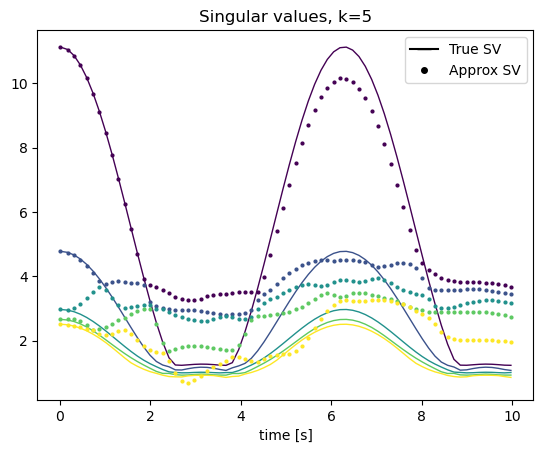

Starting integrating at t:0, with step size 0.1
Finished integrating in 200 steps, 8.428121089935303s


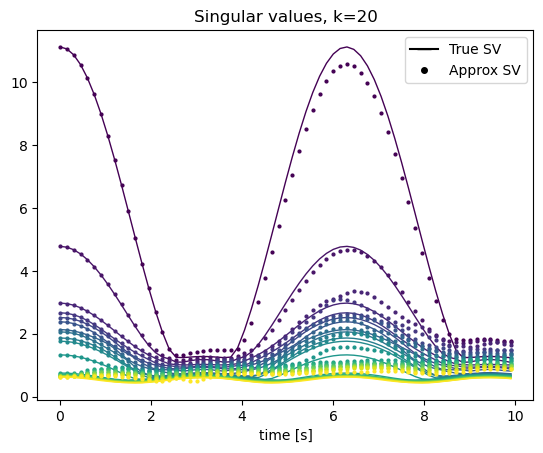

In [13]:
n=10
ks=[5, 20]
eps=1e-1
TOL = 1e-1
maxcuts=5
pointsInPlot = 60
verbose = 1
RunSVComparison(n=n, ks=ks, numPoints=pointsInPlot, TOL=TOL,
                maxcuts=maxcuts, verbose=verbose, eps=eps,
                cosMult=True, tf=10)

Here we see that for $k=5$, the singular values of the low rank approximation deviates quite a bit from the true singular values of $A(t)$, while for $k=20$ there is a much closer correspondence. An interesting observation is that in the first plot where $k=5$, the approximated singular values are greater than the true singular values, while the opposite is the case in the article by Koch and Lubich in the reference section of the project description.

Now we do the same comparisons as in 4):

In [14]:
epss = [1e-1, 1e-3, 1e-4, 1e-5]
ks = [5, 20]
TOL = 1e-1
tf=10
h0 = 0.1
resultsByKByEps2 = {}
for k in ks:
    resultsByKByEps2[k] = GetResults(epss=epss, k=k, verbose=0,
                            TOL=TOL, cosMult=True, tf=tf, h0=h0)

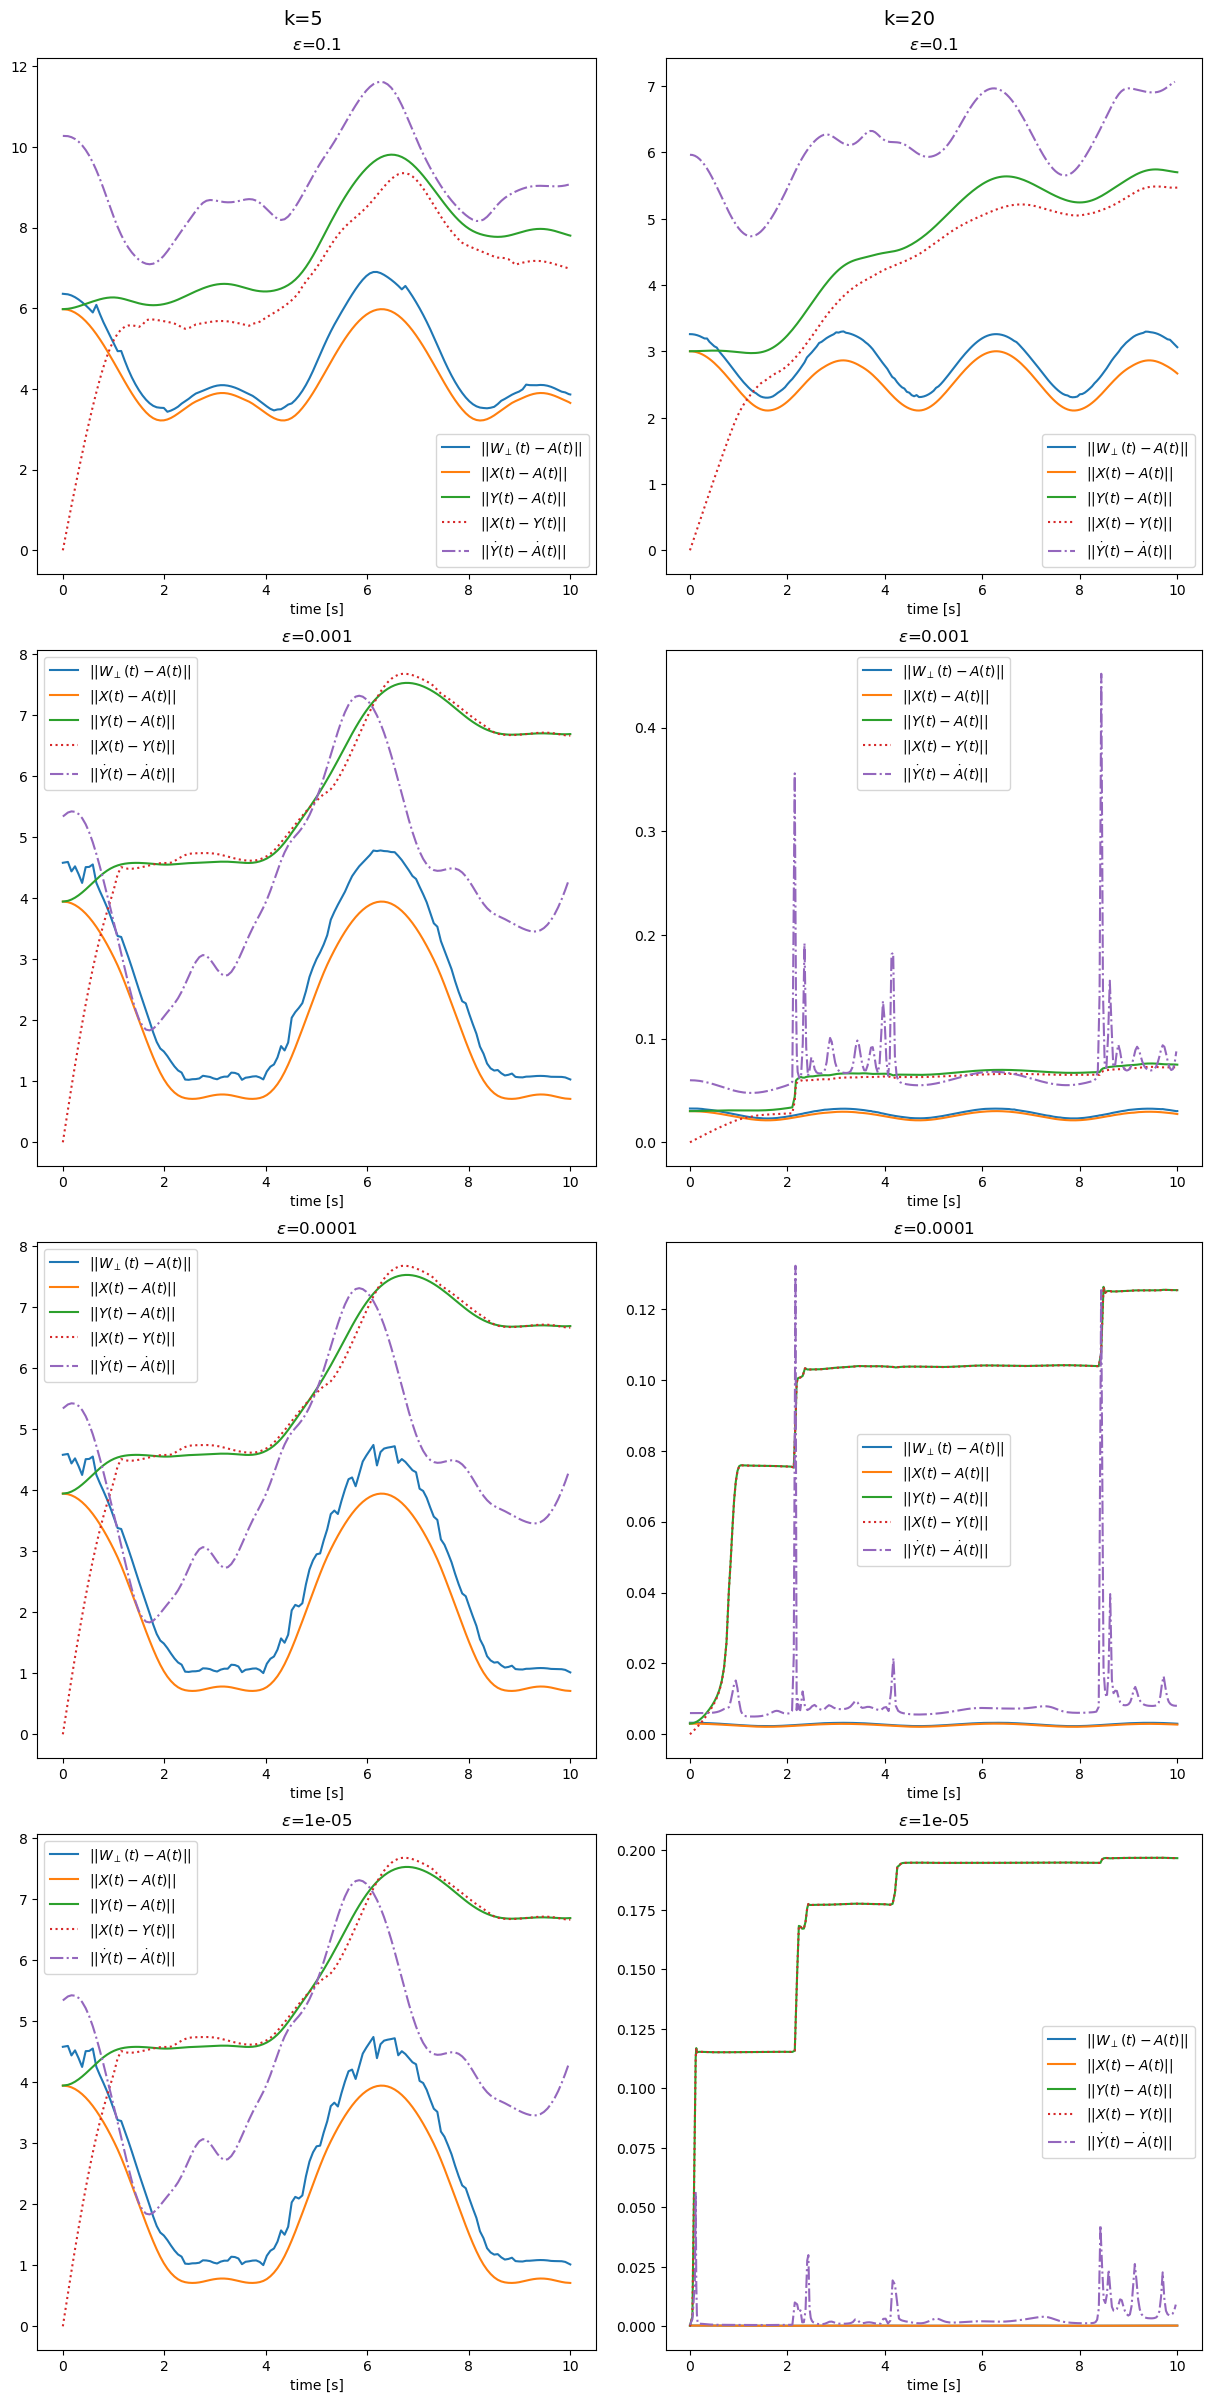

In [15]:
ksToPlot = 2
epssToPlot = len(epss)
plotErrors(resultsByKByEps2, ks, epss, ksToPlot, epssToPlot, res=6)

We observe that the dynamic low rank approximation geerally is bad, while the lanczos approximation is somewhat better and the best approximation is best. As explained in the article by Koch and Lubich, this may be because initially small eigenvalues becomes large. For Lanczos and the best approximation this is not a problem because they always compute the $k$ highest singular values, but it seems like the dynamic approachs tracks the initially large singular values, even though they shrink and is no longer largest after some time has passed. The resulting dynamic approximation is then computed with singular values which may not be approximations of the currently largest singular values, and thus the approximation may be poor. Another way to think about the error is that the best approximation is discontinuous and when trying to approximate a discontinuous function based only on its derivative, we expect large error as we have no information on how the functino jumps.

For $k=5$ we see that the error is big for different values of $\epsilon$, but for $k=20$ the approximation gets better as $\epsilon$ decreases. In The right column and all but the first row, we see that there is a big error in the derivatives where the singular are close, which may be related to the discontinuity of the best approximation. 

# Note on LLM's
ChatGPT was used to assist with createing some of the plotting routines, and for help with displaying the error tables.